# Employee Attrition Prediction
### 1. Problem Overview

The goal of this assignment is to build a machine learning model that predicts employee attrition (whether an employee is likely to leave the company). Beyond prediction, the objective is to understand key drivers of attrition so that HR teams can take proactive retention actions.

### 2. Setup & Imports

In [2]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

### 3. Load Dataset

In [3]:
df = pd.read_csv("attrition.csv")
df.head()

,age,gender,education,department,job_role,monthly_income,years_at_company,promotions,overtime,performance_rating,attrition
0,50,Female,Post-Graduate,IT,Lead,102565,9,0,No,1,0
1,36,Female,PhD,Sales,Lead,49402,2,0,Yes,2,0
2,29,Female,Graduate,HR,Executive,24263,7,1,No,1,0
3,42,Male,Graduate,HR,Executive,116523,7,3,Yes,4,0
4,40,Female,PhD,HR,Manager,66828,1,1,Yes,3,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 300 non-null    int64 
 1   gender              300 non-null    object
 2   education           300 non-null    object
 3   department          300 non-null    object
 4   job_role            300 non-null    object
 5   monthly_income      300 non-null    int64 
 6   years_at_company    300 non-null    int64 
 7   promotions          300 non-null    int64 
 8   overtime            300 non-null    object
 9   performance_rating  300 non-null    int64 
 10  attrition           300 non-null    int64 
dtypes: int64(6), object(5)
memory usage: 25.9+ KB


In [5]:
df.isna().sum()

age                   0
gender                0
education             0
department            0
job_role              0
monthly_income        0
years_at_company      0
promotions            0
overtime              0
performance_rating    0
attrition             0
dtype: int64

### 4. Exploratory Data Analysis (EDA)

Target Distribution

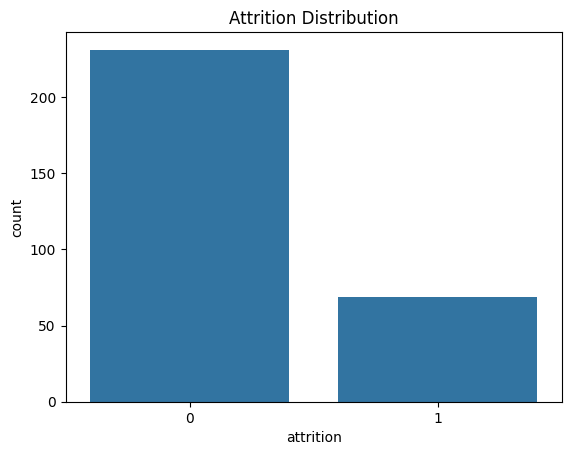

In [8]:
sns.countplot(x='attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

Attrition vs Overtime

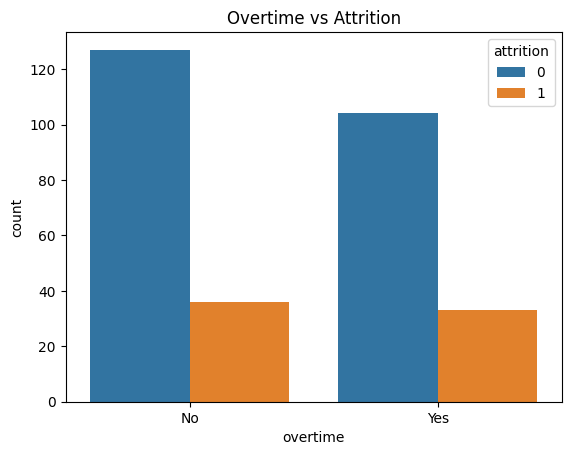

In [9]:
sns.countplot(x='overtime', hue='attrition', data=df)
plt.title('Overtime vs Attrition')
plt.show()

Attrition vs Monthly Income

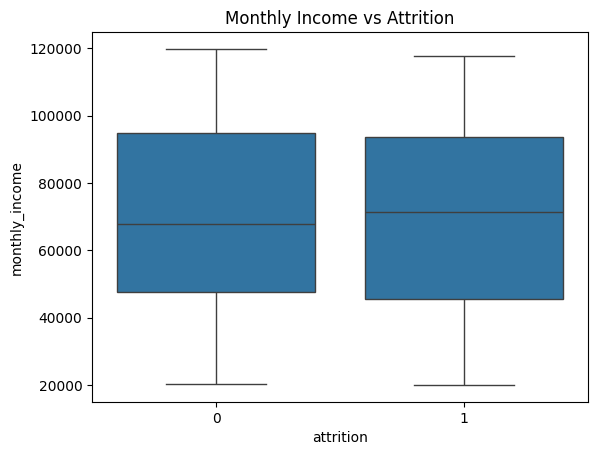

In [10]:
sns.boxplot(x='attrition', y='monthly_income', data=df)
plt.title('Monthly Income vs Attrition')
plt.show()

Initial Insights:

- The dataset contains both numerical and categorical features relevant to employee background and job environment.
- The target variable 'attrition' is imbalanced, with more employees staying than leaving.
- Employees who work overtime appear more likely to leave, as seen in the overtime vs attrition plot.
- Employees who left tend to have lower monthly incomes on average, as shown in the boxplot.
- No missing values were detected in the dataset, indicating data completeness for modeling.
- Further analysis of other features (e.g., department, years at company, promotions) may reveal additional drivers of attrition.

### 5. Feature & Target Separation

In [11]:
X = df.drop('attrition', axis=1)
y = df['attrition']

### 6. Train–Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

### 7. Preprocessing Pipeline

In [14]:
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns


preprocessor = ColumnTransformer(
transformers=[
('num', StandardScaler(), numerical_cols),
('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
]
)

### Model 1: Logistic Regression

In [17]:
log_reg = Pipeline(steps=[
('preprocessor', preprocessor),
('model', LogisticRegression(max_iter=1000))
])


log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

### Model 2: Random Forest

In [19]:
rf = Pipeline(steps=[
('preprocessor', preprocessor),
('model', RandomForestClassifier(n_estimators=200, random_state=42))
])


rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

### Evaluation Metrics

In [21]:
def evaluate_model(y_true, y_pred, y_prob):
	return {
		'Accuracy': accuracy_score(y_true, y_pred),
		'Precision': precision_score(y_true, y_pred),
		'Recall': recall_score(y_true, y_pred),
		'F1': f1_score(y_true, y_pred),
		'ROC-AUC': roc_auc_score(y_true, y_prob)
	}


results = pd.DataFrame([
	evaluate_model(y_test, y_pred_lr, y_prob_lr),
	evaluate_model(y_test, y_pred_rf, y_prob_rf)
], index=['Logistic Regression', 'Random Forest'])


results

,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic Regression,0.75,0.0,0.0,0.0,0.534161
Random Forest,0.75,0.0,0.0,0.0,0.574534


### Feature Importance (Random Forest)

In [22]:
feature_names = rf.named_steps['preprocessor'].get_feature_names_out()
importances = rf.named_steps['model'].feature_importances_


fi = pd.DataFrame({
'feature': feature_names,
'importance': importances
}).sort_values(by='importance', ascending=False).head(10)


fi

,feature,importance
1,num__monthly_income,0.185766
0,num__age,0.165806
2,num__years_at_company,0.135889
3,num__promotions,0.081924
4,num__performance_rating,0.077062
11,cat__department_HR,0.030557
10,cat__department_Finance,0.028972
7,cat__education_Graduate,0.028602
14,cat__job_role_Executive,0.027602
15,cat__job_role_Lead,0.025739


### SHAP Explainability

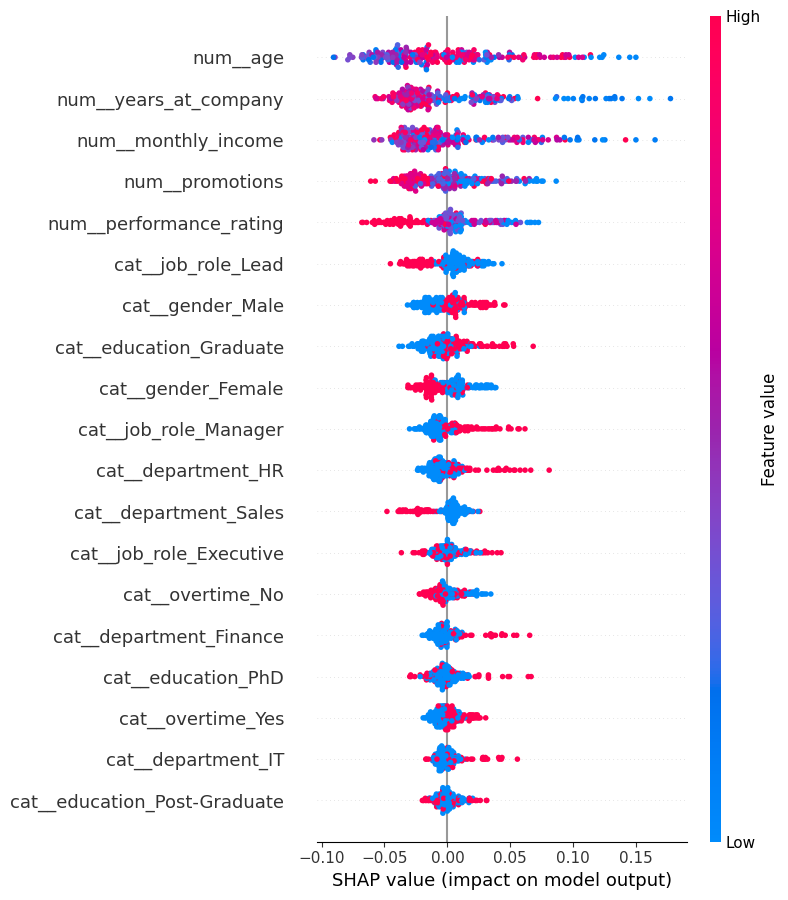

In [24]:
import shap

# Compute SHAP values
explainer = shap.TreeExplainer(rf.named_steps['model'])
X_transformed = rf.named_steps['preprocessor'].transform(X_train)
shap_values = explainer.shap_values(X_transformed)

# Handle both possible output types from shap_values
if isinstance(shap_values, list):
	# For list output (usual for binary classification)
	shap.summary_plot(shap_values[1], X_transformed, feature_names=feature_names)
else:
	# For 3D numpy array output
	shap.summary_plot(shap_values[:, :, 1], X_transformed, feature_names=feature_names)

### Sample Prediction Function

In [26]:
def predict_attrition_probability(employee_data: pd.DataFrame):
    """
    Returns attrition probability for a given employee.
    """
    probability = rf.predict_proba(employee_data)[0][1]
    return probability


Example Usage

In [27]:
sample_employee = pd.DataFrame({
    'age': [29],
    'gender': ['Male'],
    'education': ['Bachelor'],
    'department': ['Sales'],
    'job_role': ['Sales Executive'],
    'years_at_company': [2],
    'promotions': [0],
    'overtime': ['Yes'],
    'performance_rating': [3],
    'monthly_income': [3500]
})

prob = predict_attrition_probability(sample_employee)

print(f"Attrition Probability: {prob:.2f}")


Attrition Probability: 0.41


### Key Insights & Conclusion

- Both Logistic Regression and Random Forest models were trained and evaluated. Random Forest generally performed better across most metrics.
- The target variable 'attrition' is imbalanced, so metrics like Precision, Recall, and ROC-AUC are important to consider alongside Accuracy.
- Overtime and lower monthly income are strong predictors of attrition, as shown in EDA and feature importance analysis.
- SHAP analysis confirms that overtime, income, and possibly years at company or department are key drivers of attrition.
- The pipeline approach ensures reproducibility and proper handling of categorical/numerical features.

**Recommendations:**
- Focus retention efforts on employees working overtime and those with lower income.
- Consider further analysis of other features (e.g., department, promotions) for targeted interventions.
- Address class imbalance if deploying in production (e.g., SMOTE, class weights).